In [232]:
import torch
T = torch.tensor
import pandas as pd
import matplotlib.pyplot as plt

CONTEXT_LEN = 5
FEATURE_DIM = 15

In [233]:
url = 'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt'
df1 = pd.read_csv(url)

words = ['emma']
for word in df1['emma']:
  words.append(word)

chars = ['.'] + list(map(chr, range(97, 123)))
stoi = {ch:i for i, ch in enumerate(chars)}

# Split it into train, dev, test sets
dataSplits = [[]for i in range(3)]
ind = 0

p = T([0.8, 0.1, 0.1])
multiSamples = torch.multinomial(p, num_samples=len(words), replacement=True)

for i in multiSamples:
    dataSplits[i].append(words[ind])
    ind += 1

    

alphas = list(map(chr, range(97, 123)))
chars = ['.'] + alphas
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

VOCAB_SIZE = len(chars)

# Creating Input-Output Lists
X = [[]for i in range(3)]; Y = [[]for i in range(3)]
for dataSetInd in range(3):
    for word in dataSplits[dataSetInd]:
#         word += '.' Avoided because of inefficiency
        context = [0]*CONTEXT_LEN
        for char in word:

            X[dataSetInd].append(context)
            Y[dataSetInd].append(stoi[char])
            
            context = context[1:] + [stoi[char]]
        
        X[dataSetInd].append(context)
        Y[dataSetInd].append(stoi['.'])   

In [267]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in)**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias != None:
            self.out += self.bias
        
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias == None else [self.bias])
    
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
    
class BatchNorm1d:
    def __init__(self, dim, momentum=0.01, eps=1e-5):
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.training = True
        self.mean_running = torch.zeros(dim)
        self.var_running = torch.ones(dim)
        self.eps = eps
        self.dim = dim
        self.momentum = momentum

    def __call__(self, x):        
        if self.training:
            bnmean = x.mean(0, keepdim=True)
            bnvar = x.var(0, keepdim=True)
            self.bnmean = bnmean
            self.bnvar = bnvar
            self.out = self.gamma*((x - bnmean)/torch.sqrt(bnvar + self.eps))+self.beta
        else:
            self.out = self.gamma*((x - self.mean_running)/torch.sqrt(self.var_running + self.eps)) + self.beta
        if self.training:
            with torch.no_grad():
                self.mean_running = ((1-self.momentum)*self.mean_running) + self.momentum*bnmean
                self.var_running = ((1-self.momentum)*self.var_running) + self.momentum*bnvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
        
C = torch.randn((VOCAB_SIZE, FEATURE_DIM), generator=g)

In [268]:
g = torch.Generator().manual_seed(2147483647)
HIDDEN_LAYER_OUT = 200

layers = [
    Linear(CONTEXT_LEN*FEATURE_DIM, HIDDEN_LAYER_OUT, bias=False), BatchNorm1d(HIDDEN_LAYER_OUT), Tanh(),
    Linear(HIDDEN_LAYER_OUT, HIDDEN_LAYER_OUT, bias=False), BatchNorm1d(HIDDEN_LAYER_OUT), Tanh(),
    Linear(HIDDEN_LAYER_OUT, HIDDEN_LAYER_OUT, bias=False), BatchNorm1d(HIDDEN_LAYER_OUT), Tanh(),
    Linear(HIDDEN_LAYER_OUT, HIDDEN_LAYER_OUT, bias=False), BatchNorm1d(HIDDEN_LAYER_OUT), Tanh(),
    Linear(HIDDEN_LAYER_OUT, VOCAB_SIZE, bias=True)
]

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

In [269]:
xTrain, yTrain = torch.tensor(X[0]), torch.tensor(Y[0])
ITERATIONS = 300000
BATCH_SIZE = 100

nlls = []
for iteration in range(ITERATIONS):
    batchIndexes = torch.randint(0, xTrain.shape[0], (BATCH_SIZE, ))
    
    xBatch = xTrain[batchIndexes]
    yBatch = yTrain[batchIndexes]
    
    emb = C[xBatch]
    x = emb.view(-1, CONTEXT_LEN*FEATURE_DIM)    
    
    for layer in layers:
        x = layer(x)
    loss = torch.nn.functional.cross_entropy(x, yBatch)
    nlls.append(loss.log10().item())
    
#     Backward Pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if iteration < ITERATIONS/3 else 0.01 if iteration < 2*ITERATIONS/3 else 0.001
    for p in parameters:
        p.data -= lr * p.grad
    
    if iteration%10000 == 0: 
        print(loss.item())

3.466586112976074
1.837438941001892
2.0081467628479004
1.9059433937072754
1.866139531135559
1.8482775688171387
2.0305914878845215
1.7594897747039795
1.7448307275772095
1.7698074579238892
1.6425542831420898
1.7609779834747314
1.5437275171279907
1.7055221796035767
1.8167288303375244
1.4956954717636108
1.4770567417144775
1.6486525535583496
1.7046098709106445
1.7837392091751099
1.352854609489441
1.7430192232131958
1.4091061353683472
1.6457946300506592
1.8285022974014282
1.5558050870895386
1.556000828742981
1.7179710865020752
1.5804234743118286
1.4748035669326782


layer 2 (      Tanh): mean -0.00, std 0.70, saturated: 18.63%
layer 5 (      Tanh): mean -0.01, std 0.75, saturated: 22.60%
layer 8 (      Tanh): mean -0.01, std 0.80, saturated: 23.50%
layer 11 (      Tanh): mean -0.00, std 0.82, saturated: 31.07%


Text(0.5, 1.0, 'activation distribution')

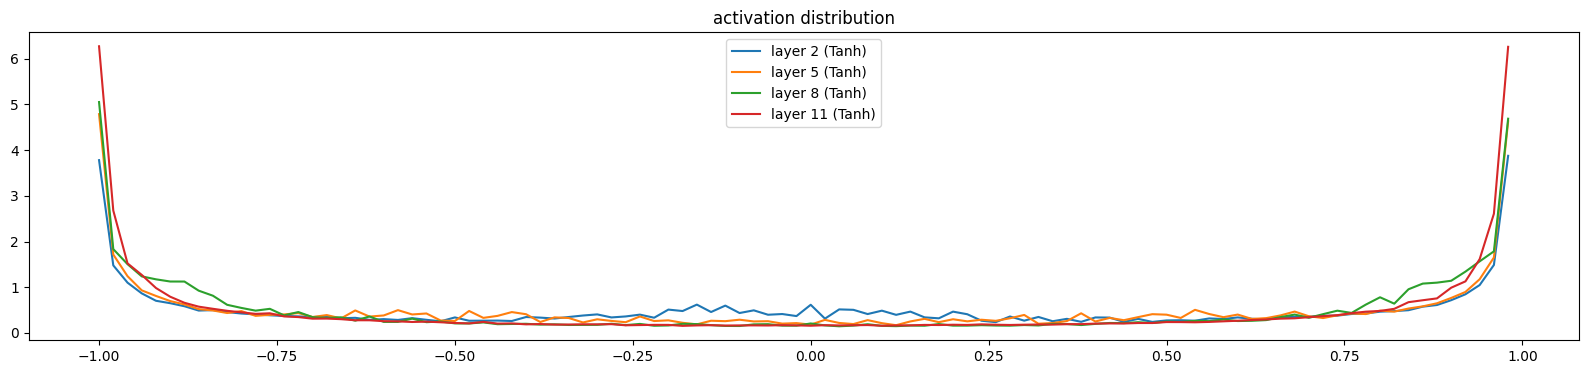

In [274]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

In [275]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

/var/folders/q8/nm5dszqn7lb909617w1pkpk00000gn/T/ipykernel_35455/214208553.py:6: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:491.)
  t = layer.out.grad


AttributeError: 'NoneType' object has no attribute 'mean'

<Figure size 2000x400 with 0 Axes>

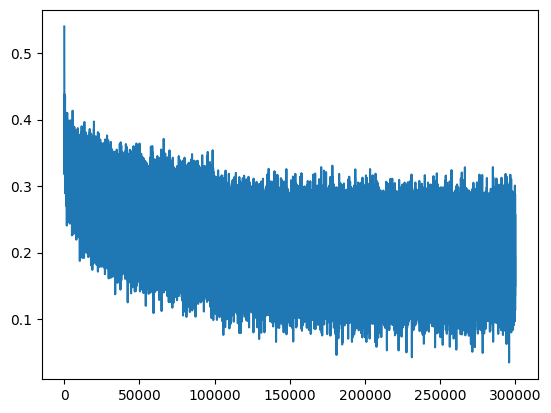

In [276]:
plt.plot(nlls)
# print(nlls)

In [ ]:
# Post Training, wrapping the BatchNormId layers into the preceding Linear Layers



In [273]:
def split_loss(split):
    inputs, outputs = {
        "train": (X[0], Y[0]),
        "dev": (X[1], Y[1]),
        "test": (X[2], Y[2])
    }[split]
    
    emb = C[torch.tensor(inputs)]
    x = emb.view(-1, CONTEXT_LEN*FEATURE_DIM)    
    
    for layer in layers:
        if isinstance(layer, BatchNorm1d):
            layer.training = False
        x = layer(x)
    loss = torch.nn.functional.cross_entropy(x, torch.tensor(outputs))
    print(f"{split} split loss: {loss.item()}")
    
split_loss("train")
split_loss("dev")

train split loss: 1.5389474630355835
dev split loss: 2.128129720687866


In [ ]:
1 BN:train split loss: 1.5389474630355835, dev split loss: 2.128129720687866